# LDA similarity

https://www.kaggle.com/ktattan/lda-and-document-similarity

### imports

In [129]:
import PyPDF2
import textract
import os

import numpy as np
import pandas as pd
import seaborn as sns
import re
import time
from scipy.stats import entropy
import matplotlib.pyplot as plt
from random import random

from gensim.models import word2vec
import gensim.downloader as api

import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics, datasets, neighbors, decomposition

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist

### load data

In [4]:
df = pd.read_csv('../data/raw/Consumer_Complaints.csv' )

In [42]:
target_columns = ['Product','Complaint ID']
feature_columns = ['Consumer complaint narrative','Complaint ID']

df_nona = pd.DataFrame(df.dropna(subset = target_columns).dropna(subset = feature_columns))
df_nona

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
60,12/27/2018,Debt collection,Other debt,Attempts to collect debt not owed,Debt is not yours,I am disputing this debt for XXXX XXXX that is...,Company believes the complaint is the result o...,"CCS Financial Services, Inc.",IL,60471,NaN,Consent provided,Web,12/27/2018,Closed with explanation,Yes,NaN,3110285
91,12/27/2018,Debt collection,Federal student loan debt,False statements or representation,Attempted to collect wrong amount,Ok education credit management corporation XXX...,Company has responded to the consumer and the ...,"ECMC Group, Inc.",MA,NaN,NaN,Consent provided,Web,12/27/2018,Closed with explanation,Yes,NaN,3109183
146,12/26/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,The Account from Ability Recovery Services has...,Company has responded to the consumer and the ...,"Ability Recovery Services, LLC",GA,30047,Servicemember,Consent provided,Web,12/26/2018,Closed with explanation,Yes,NaN,3109471
171,12/26/2018,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made cash & check deposit at my banks atm on...,Company has responded to the consumer and the ...,BB&T CORPORATION,FL,342XX,NaN,Consent provided,Web,12/26/2018,Closed with explanation,Yes,NaN,3109026
172,12/26/2018,Debt collection,Other debt,False statements or representation,Attempted to collect wrong amount,Monterey Collection is trying to collect on a ...,Company believes it acted appropriately as aut...,Monterey Financial Services LLC,MS,392XX,Servicemember,Consent provided,Web,12/26/2018,Closed with explanation,Yes,NaN,3110084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819812,03/19/2015,Credit reporting,NaN,Incorrect information on credit report,Account terms,"XXXX XXXX SrXXXX XXXX XXXX XXXX, Ca XXXX XXXX ...",NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,95741,Servicemember,Consent provided,Web,04/17/2015,Closed with non-monetary relief,Yes,No,1292051
819816,03/19/2015,Student loan,Non-federal student loan,Dealing with my lender or servicer,Having problems with customer service,"On XXXX XXXX, XXXX I submitted documentation t...",Company chooses not to provide a public response,"ECMC Group, Inc.",CA,NaN,NaN,Consent provided,Web,03/25/2015,Closed with explanation,Yes,No,1291923
819820,03/19/2015,Student loan,Non-federal student loan,Can't repay my loan,Can't decrease my monthly payments,I am trying to deal with Navient ( formerly XX...,NaN,"Navient Solutions, LLC.",NY,142XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290841
819824,03/19/2015,Credit card,NaN,Credit determination,NaN,i recently closed and paid off my citizens ban...,NaN,"CITIZENS FINANCIAL GROUP, INC.",MA,023XX,NaN,Consent provided,Web,03/20/2015,Closed with explanation,Yes,No,1291547


In [8]:
STOP_WORDS = nltk.corpus.stopwords.words('english')

In [12]:
# tokenizer function same as in preprocess notebook
def tokenize_text(text):
    
    text_tokenized = nltk.word_tokenize(text)
    text_tokenized = [x.lower() for x in text_tokenized]
    wordlist = []
    for word in text_tokenized: 
        
        if ((word not in STOP_WORDS) and (len(word)>2)):            
            wordlist.append(word)
        # if not (word.isalnum()):            
        # text_tokenized.remove(word)
            
    return(wordlist)

In [67]:
sentences = df_nona['Consumer complaint narrative']
sentences_tok = df_nona['Consumer complaint narrative'].apply(lambda x: tokenize_text(x))
sent_labels_1 = df_nona['Product']
sent_labels_2 = df_nona['Sub-product']
sent_id = range(len(sentences))
sent = pd.DataFrame({'raw' : sentences, 
                     'tokenized' : sentences_tok, 
                     'id' : sent_id, 
                     'lab1' : 'sent_labels_1', 
                     'lab2': 'sent_labels_2'}).set_index('id')

In [124]:
sent

,raw,tokenized,lab1,lab2,tokenized_k
id,,,,,
0,I am disputing this debt for XXXX XXXX that is...,"[disputing, debt, xxxx, xxxx, currently, colle...",Debt collection,Other debt,"[disputing, debt, xxxx, xxxx, currently, colle..."
1,Ok education credit management corporation XXX...,"[education, credit, management, corporation, x...",Debt collection,Federal student loan debt,"[education, credit, management, corporation, x..."
2,The Account from Ability Recovery Services has...,"[account, ability, recovery, services, removed...","Credit reporting, credit repair services, or o...",Credit reporting,"[account, ability, recovery, services, removed..."
3,I made cash & check deposit at my banks atm on...,"[made, cash, check, deposit, banks, atm, xx/xx...",Checking or savings account,Checking account,"[made, cash, check, deposit, banks, atm, xx/xx..."
4,Monterey Collection is trying to collect on a ...,"[monterey, collection, trying, collect, debt, ...",Debt collection,Other debt,"[monterey, collection, trying, collect, debt, ..."
...,...,...,...,...,...
354571,"XXXX XXXX SrXXXX XXXX XXXX XXXX, Ca XXXX XXXX ...","[xxxx, xxxx, srxxxx, xxxx, xxxx, xxxx, xxxx, x...",Credit reporting,NaN,"[xxxx, xxxx, xxxx, xxxx, xxxx, xxxx, xxxx, xxx..."
354572,"On XXXX XXXX, XXXX I submitted documentation t...","[xxxx, xxxx, xxxx, submitted, documentation, e...",Student loan,Non-federal student loan,"[xxxx, xxxx, xxxx, submitted, documentation, e..."
354573,I am trying to deal with Navient ( formerly XX...,"[trying, deal, navient, formerly, xxxx, xxxx, ...",Student loan,Non-federal student loan,"[trying, deal, navient, formerly, xxxx, xxxx, ..."


In [120]:
sent = pd.DataFrame({'raw' : sentences, 
                     'tokenized' : sentences_tok, 
                     'id' : sent_id, 
                     'lab1' : sent_labels_1, 
                     'lab2': sent_labels_2}).set_index('id')

### word frequency

In [69]:
# first get a list of all words
all_words = [word for text in list(sent['tokenized']) for word in text]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

192803

In [70]:
top_words = fdist.most_common(9000)
#top_words[-20:]

In [123]:
top_words,_ = zip(*fdist.most_common(9000))
top_words = set(top_words)
def keep_top_words(text):
    return [word for word in text if word in top_words]
sent['tokenized_k'] = sent['tokenized'].apply(keep_top_words)

In [72]:
# document length

sent['doc_len'] = sent['tokenized'].apply(lambda x: len(x))
doc_lengths = list(sent['doc_len'])
sent.drop(labels='doc_len', axis=1, inplace=True)

In [73]:
# only keep articles with more than 35 tokens, otherwise too short
sent = sent[sent['tokenized_k'].map(len) >= 30]
# make sure all tokenized items are lists
sent = sent[sent['tokenized_k'].map(type) == list]
sent.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(sent), "articles")

After cleaning and excluding short aticles, the dataframe now has: 283678 articles


### Train lda

 trainining takes about 1 min pro 10 000 texts/rows

In [74]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized_k'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized_k']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(sent), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [75]:
dictionary,corpus,lda = train_lda(sent)

Time to train LDA model on  283678 articles:  31.959677688280742 min


### See what's in the box (model)

739
[(36, 1), (54, 1), (71, 2), (363, 1), (383, 1), (552, 1), (1397, 2), (1426, 1), (1527, 1), (1585, 1), (1891, 1), (2471, 2), (2691, 1), (3160, 3), (3547, 1), (3759, 1), (3764, 1), (3767, 1), (3777, 1), (4748, 1), (5014, 1), (5165, 1), (7099, 1), (7298, 1), (7865, 1), (8019, 2), (8072, 2), (8073, 1), (8074, 2)]
['šššššš', 'e.g.', 'prayer', 'practice', 'city', 'letter', 'freedom', 'religion', 'foundation', 'city', 'saginaw', 'city', 'council', 'jan.', '2014', 'online', 'http', 'saginaw', 'materials', 'visited', 'may', '2014', 'available', 'clerk', 'court™s', 'case', 'file', 'prayer', 'practice', 'cobb', 'county', 'georgia', 'described', 'cobb', 'county', '410', 'supp']


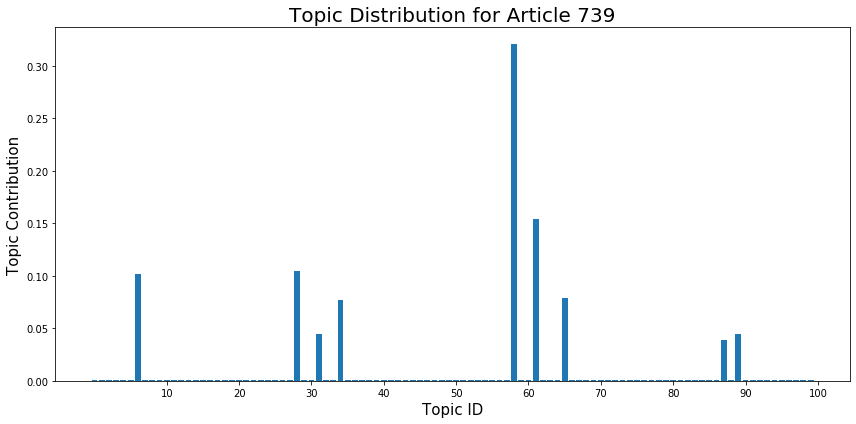

In [242]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=4)

# select and article at random from train_df
random_article_index = np.random.randint(len(sent))
bow = dictionary.doc2bow(sent.iloc[random_article_index,2])
print(random_article_index)
print(bow)

print(sent.iloc[random_article_index,2])

# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])
len(doc_distribution)

# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

### and here it comes finally: similarity

In [76]:
# get all topic distributions into a matrix (one row is one sentence/text, one column is one topic)
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(283678, 100)

In [109]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    #p = query[None,:].T # take transpose
    p = (new_doc_distribution * np.ones((len(matrix),len(new_doc_distribution)))).T
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    ent1 = entropy(p,m)
    ent2 = entropy(q,m)
    return np.sqrt(0.5*( ent1 + ent2))

In [110]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [141]:
# select and article at random from test_df
random_article_index = np.random.randint(len(sent))

new_bow = dictionary.doc2bow(sent.iloc[random_article_index,4])
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

print(random_article_index)
print(sent.iloc[random_article_index,0])

226409
After entering some basic information into the University XXXX website, I had received several calls in a few days ' time. An enrollment counselor contacted me to ask about my interest and aggressively pursued my enrollment in coursework for a XXXX Degree in XXXX from the XXXX University XXXX forum, explaining a XXXX degree would boost my chances of getting a high-paying job in the field of my choice. The format and cost were explained and the first course started the following Tuesday. I began the coursework expecting preparatory instruction for the beginning of a career. I was, in fact, given little guidance toward a secure, high-paying job in the field and I believe the education i received in this coursework has not expanded my opportunities for a career in the way I was led to believe.


In [142]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [143]:
most_similar_df = sent[sent.index.isin(most_sim_ids)]

for i in range(len(most_similar_df)):
    row = most_similar_df.iloc[i,:]
    
    print (row['lab1'])
    print (row['lab2'])
    print()
    print (row['raw'])    
    print()
    print()    

most_similar_df.to_csv('./'+str(random())+'.csv',)

Credit card or prepaid card
General-purpose credit card or charge card

XXXX/XXXX/XXXX I discovered a negative account with Barclays Bank XXXX ( Delaware ) on my credit reports, which had apparently went into collections and onto the reports in XXXX. Prior to XXXX XXXX, XXXX, I was n't aware it existed. I then called Barclays to dispute ownership of the account. 


XXXX/XXXX/XXXX I initiated a dispute with all three credit reporting agencies, regarding the Barclays account. 

XXXX/XXXX/XXXX I filed an Identity Theft Report with the Federal Trade Commission and proceeded to follow the outline of steps to follow which they provide in cases of credit card fraud. 

XXXX/XXXX/XXXX I received a reply via email from a Barclays employee, XXXX XXXX. 

XXXX/XXXX/XXXX I sent a response to XXXX XXXX and also attempted to reach him on the phone over the next two days with no luck. 

XXXX/XXXX/XXXX I called Barclays again and spoke with a women who said she worked in the Fraud Department whose name 